# Machine Learning con PySpark & MLflow Tracking

Questo notebook implementa **due modelli di machine learning distribuito** utilizzando PySpark MLlib, con tracking completo degli esperimenti tramite MLflow:

1. **ALS Recommendation System** - Sistema di raccomandazione prodotti basato su Collaborative Filtering
2. **Random Forest Classifier** - Classificazione customer segment per marketing personalizzato

Utilizzeremo un approccio a due fasi per ottimizzare i tempi:

**Development Phase (20% data)**:
- Esplorazione iperparametri su sample
- Identificazione configurazioni promettenti
- Training veloce per iterazioni rapide

**Production Phase (100% data)**:
- Re-training su dataset completo
- Valutazione finale
- Selezione del modello definitivo


**Tutti** gli esperimenti saranno tracciati in **MLflow**:
- Parameters (configurazioni modelli)
- Metrics (performance)
- Models (artifacts)
- Tags (development/production)

Lo scopo finale e' selezionare i migliori modelli per deployment production.

In [1]:
# IMPORTS

import os
import sys
import time
#import json
import itertools
import requests
from pathlib import Path
#from datetime import datetime

# Data manipulation
import pandas as pd
#import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
#from pyspark.sql.types import *

# MLlib
from pyspark.ml.recommendation import ALS
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# MLflow
import mlflow
import mlflow.spark
from mlflow.tracking import MlflowClient

# Add project root to path
project_root = Path.cwd().parent if "notebooks" in str(Path.cwd()) else Path.cwd()
sys.path.append(str(project_root))

# Import configuration
from config.spark_config import get_spark_session
from config.mlflow_config import setup_mlflow, get_mlflow_client, log_model
from config.minio_config import get_s3a_path

# Settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Silence log
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger("mlflow.spark").setLevel(logging.ERROR)

print("All imports successful!")

/home/paolo/anaconda3/envs/pyspark/lib/python3.10/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


All imports successful!


In [2]:
# PATHS & PARAMETERS CONFIGURATION

# Training Configuration
SAMPLE_FRACTION_DEV = 0.2
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
RANDOM_SEED = 42
TOP_N = 3

# Output directories
RESULTS_DIR = project_root / "docs" / "results"
GRAPH_DIR = project_root / "docs" / "graphs"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
GRAPH_DIR.mkdir(parents=True, exist_ok=True)

# MinIO paths  
als_data_path = get_s3a_path("ml_data/", "user_item_interactions")
rf_data_path = get_s3a_path("ml_data/", "customer_features")
predictions_path = get_s3a_path("predictions")

print("MinIO paths configured:")
print(f"  User-Item Interactions: {als_data_path}")
print(f"  Customer Features: {rf_data_path}")
print(f"  Predictions: {predictions_path}")

MinIO paths configured:
  User-Item Interactions: s3a://bigdata-ecommerce/ml_data/user_item_interactions
  Customer Features: s3a://bigdata-ecommerce/ml_data/customer_features
  Predictions: s3a://bigdata-ecommerce/predictions


In [3]:
# MLFLOW EXPERIMENT SETUP

print("=" * 70)
print("MLFLOW EXPERIMENT SETUP")
print("=" * 70 + "\n")

os.environ["MLFLOW_LOGGING_LEVEL"] = "ERROR"
os.environ["MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR"] = "false"

MLFLOW_EXPERIMENT_NAME = "ecommerce-ml-models"
experiment_id = setup_mlflow(MLFLOW_EXPERIMENT_NAME)

client = get_mlflow_client()
experiment = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)

print(f"\nMLflow experiment ready")

MLFLOW EXPERIMENT SETUP

S3 client configured for MinIO at localhost:9000
Using existing experiment: ecommerce-ml-models (ID: 1)
MLflow UI: http://localhost:5000
Artifacts Location: s3://bigdata-ecommerce/mlflow-artifacts/

MLflow experiment ready


In [6]:
# SPARK SESSION CREATION

print("=" * 70)
print("SPARK SESSION CREATION")
print("=" * 70 + "\n")

os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

spark = get_spark_session(
    app_name="Notebook-04-PySpark-ML",
    enable_delta=True
)

# Display key configuration
print("\nKey Spark Configurations:")
conf = spark.sparkContext.getConf()
important_configs = [
    "spark.app.name",
    "spark.driver.memory",
    "spark.sql.shuffle.partitions",
    "spark.default.parallelism",
    "spark.memory.fraction",
    "spark.sql.adaptive.enabled"
]
for config in important_configs:
    print(f"  {config}: {conf.get(config, 'Not set')}")

SPARK SESSION CREATION

Found 5 JAR files
Spark Session created: Notebook-04-PySpark-ML
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled

Key Spark Configurations:
  spark.app.name: Notebook-04-PySpark-ML
  spark.driver.memory: 10g
  spark.sql.shuffle.partitions: 24
  spark.default.parallelism: 12
  spark.memory.fraction: 0.6
  spark.sql.adaptive.enabled: true


In [7]:
# HELPER FUNCTIONS

def save_results(data, filename):
    """
    Save results to CSV in docs/results/.

    Args:
        data: Dictionary or pandas DataFrame.
        filename: Output filename.
    """
    filepath = RESULTS_DIR / filename
    if isinstance(data, dict):
        pd.DataFrame([data]).to_csv(filepath, index=False)
    else:
        data.to_csv(filepath, index=False)
    print(f"Saved: {filename}")

def prepare_rf_features(train_df, test_df, numeric_features, categorical_features=None):
    """
    Fit StringIndexers on train_df, transform both train and test.
    Returns transformed (train, test) DataFrames with 'features' and 'label' columns.

    Args:
        train_df: Training DataFrame with raw columns.
        test_df: Test DataFrame with raw columns.
        numeric_features: List of numeric feature column names.
        categorical_features: List of categorical feature column names (default: ['region']).

    Returns:
        tuple: (train_transformed, test_transformed, indexer_models)
            indexer_models is a dict for reuse in predictions.
    """
    if categorical_features is None:
        categorical_features = ["region"]

    # Stage 1: StringIndexer for categorical features
    string_indexer = StringIndexer(
        inputCol="region",
        outputCol="region_indexed",
        handleInvalid="keep"
    )
    string_indexer_model = string_indexer.fit(train_df)

    # Stage 2: StringIndexer for label
    label_indexer = StringIndexer(
        inputCol="customer_segment",
        outputCol="label",
        handleInvalid="keep"
    )
    label_indexer_model = label_indexer.fit(train_df)

    # Stage 3: VectorAssembler
    feature_cols = numeric_features + ["region_indexed"]
    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="features",
        handleInvalid="keep"
    )

    # Transform train
    train_indexed = string_indexer_model.transform(train_df)
    train_indexed = label_indexer_model.transform(train_indexed)
    train_transformed = assembler.transform(train_indexed)

    # Transform test
    test_indexed = string_indexer_model.transform(test_df)
    test_indexed = label_indexer_model.transform(test_indexed)
    test_transformed = assembler.transform(test_indexed)

    indexer_models = {
        "string_indexer": string_indexer_model,
        "label_indexer": label_indexer_model,
        "assembler": assembler,
    }

    return train_transformed, test_transformed, indexer_models


# Shared evaluators (reused across all phases)
rmse_evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="rating", predictionCol="prediction"
)
mae_evaluator = RegressionEvaluator(
    metricName="mae", labelCol="rating", predictionCol="prediction"
)
acc_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)

# Numeric features for RF (constant across all phases)
RF_NUMERIC_FEATURES = [
    "recency", "frequency", "monetary",
    "avg_transaction", "unique_products", "age"
]

print("Helper functions and shared evaluators defined!")

Helper functions and shared evaluators defined!


## Dataset Overview

I dataset per il machine learning sono stati preparati nel Notebook 3:

### 1. User-Item Interactions (per ALS)
**Path**: `s3a://bigdata-ecommerce/ml_data/user_item_interactions`

**Schema**:
- `user_id` (int): Numeric customer ID
- `item_id` (int): Numeric product ID
- `rating` (double): Rating implicito derivato dalle transazioni
- `customer_id` / `product_id`: ID originali (string)

**Uso**: Collaborative Filtering per raccomandazioni personalizzate

### 2. Customer Features (per Random Forest)
**Path**: `s3a://bigdata-ecommerce/ml_data/customer_features`

**Schema**:
- `customer_id` (string): Customer ID
- `recency` (int): Giorni dall'ultimo acquisto
- `frequency` (long): Numero totale di acquisti
- `monetary` (double): Spesa totale
- `avg_transaction` (double): Valore medio transazione
- `unique_products` (long): Prodotti diversi acquistati
- `customer_segment` (string): Segmento (VIP/Regular/Occasional) -- LABEL
- `age` (int): Eta' cliente
- `region` (string): Regione geografica

**Uso**: Classificazione segmenti per targeting marketing

# PySpark MLlib & MLFlow Tracking

## Architettura MLlib

**MLlib** e' la libreria di Machine Learning distribuito di Spark, progettata per scalare su dataset di grandi dimensioni.

1. **DataFrame-based API** (high-level)
   - Integrata con Spark SQL
   - Type-safe e ottimizzata
   - API simile a scikit-learn

2. **Pipeline API**
   - Composizione di trasformazioni
   - Riproducibilita' garantita
   - Fit-Transform pattern

3. **ML Algorithms**
   - Classification: Random Forest, Logistic Regression, GBT, etc.
   - Regression: Linear Regression, Random Forest Regression, etc.
   - Clustering: K-Means, Gaussian Mixture, etc.
   - Collaborative Filtering: ALS

4. **Feature Engineering**
   - Transformers: VectorAssembler, StringIndexer, etc.
   - Feature extraction, selection, normalization

## Pipeline API

**Transformer**: Trasforma un DataFrame in un altro (metodo: `transform()`)

**Estimator**: Addestra su dati e produce un Transformer (metodo: `fit()` --> Model)

**Pipeline**: Sequenza di Transformers ed Estimators

**Pattern Tipico**: Data --> Feature Engineering (Transformers) --> ML Algorithm (Estimator) --> Predictions

## Metriche di Valutazione

### Regression Metrics (ALS)
- **RMSE** (Root Mean Squared Error): Penalizza errori grandi, stesso range dei rating
- **MAE** (Mean Absolute Error): Errore medio assoluto, meno sensibile a outliers

### Classification Metrics (Random Forest)
- **Accuracy**: Proporzione di predizioni corrette (0-1)
- **F1 Score**: Media armonica di precision e recall

## MLFlow Tracking

**MLflow** traccia e salva tutti i training eseguiti fornendo una panoramica chiara dei modelli addestrati, confrontarli ed estrarre quello desiderato in qualsiasi momento.

1. **Set tags** (`mlflow.set_tag("phase", "development" or "production")`)
2. **Log parameters** (`mlflow.log_param("param1", value1)`)
3. **Train model** (`model = algorithm.fit(train_data)`)
4. **Evaluate** (`predictions = model.transform(test_data)`)
5. **Log metrics** (`mlflow.log_metric("primary_metric", metric)`)

# ALS Recommendation System

## Alternating Least Squares (ALS)

**ALS** e' un algoritmo di Collaborative Filtering per sistemi di raccomandazione.

### Come Funziona

1. **Matrix Factorization**:
   - User-Item rating matrix (sparse) --> Due matrici di fattori latenti (dense)
   - User factors (U): caratteristiche utenti
   - Item factors (I): caratteristiche prodotti
   - Predizione: `rating ~ U x I`

2. **Alternating Optimization**:
   - Fissa U, ottimizza I
   - Fissa I, ottimizza U
   - Alterna fino a convergenza

3. **Implicit Feedback**:
   - Il nostro caso: rating impliciti da transazioni
   - Non abbiamo rating espliciti (1-5 stelle)
   - Usiamo frequenza acquisti, importo speso, etc.

### Iperparametri

**rank**: Numero di fattori latenti (5-15)
**maxIter**: Iterazioni ALS (10-20)
**regParam**: Regularization (0.01-1.0) - previene overfitting

## Development Phase - Esplorazione Iperparametri

La fase di development usa un **sample del 20%** del dataset per:
- Esplorare rapidamente lo spazio degli iperparametri
- Identificare configurazioni promettenti
- Ridurre i tempi di training

### Grid Search

Testeremo **27 combinazioni**:
- `rank`: [5, 10, 15] - dimensionalita' fattori latenti
- `maxIter`: [10, 15, 20] - numero iterazioni
- `regParam`: [0.01, 0.1, 1.0] - regolarizzazione

In [8]:
# ALS DEV: LOAD & SPLIT DATA

print("=" * 70)
print("ALS DEVELOPMENT PHASE")
print("=" * 70 + "\n")

print(f"Development configuration:")
print(f"  Sample fraction: {SAMPLE_FRACTION_DEV} ({SAMPLE_FRACTION_DEV*100:.0f}%)")
print(f"  Train/test split: {TRAIN_RATIO}/{TEST_RATIO}")
print(f"  Random seed: {RANDOM_SEED}")

# Load user-item interactions
print("\nLoading user-item interactions...")
try:
    interactions_full = spark.read.format("delta").load(als_data_path)
    interactions_count = interactions_full.count()
    print(f"Loaded {interactions_count:,} interactions")
    print("Schema:")
    interactions_full.printSchema()
except Exception as e:
    print(f"Error loading interactions: {e}")
    raise

# Sample for development
print(f"\nLoading {SAMPLE_FRACTION_DEV*100:.0f}% sample for development...")
start_time = time.time()

interactions_dev = interactions_full.sample(fraction=SAMPLE_FRACTION_DEV, seed=RANDOM_SEED)
interactions_dev.cache()

dev_count = interactions_dev.count()
load_time = time.time() - start_time

print(f"  Sample loaded: {dev_count:,} interactions")
print(f"  Load time: {load_time:.1f} seconds")

# Quick statistics
print("\nSample statistics:")
print(f"  Unique customers: {interactions_dev.select('customer_id').distinct().count():,}")
print(f"  Unique products: {interactions_dev.select('product_id').distinct().count():,}")
print(f"  Rating range: [{interactions_dev.agg(F.min('rating')).collect()[0][0]:.2f}, {interactions_dev.agg(F.max('rating')).collect()[0][0]:.2f}]")

# Split
print("\n" + "=" * 70)
print("TRAIN/TEST SPLIT")
print("=" * 70 + "\n")

print(f"Splitting data ({TRAIN_RATIO}/{TEST_RATIO})...")
train_dev, test_dev = interactions_dev.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)
train_dev.cache()
test_dev.cache()

train_dev_count = train_dev.count()
test_dev_count = test_dev.count()

print(f"  Train set: {train_dev_count:,} interactions ({train_dev_count/dev_count*100:.1f}%)")
print(f"  Test set: {test_dev_count:,} interactions ({test_dev_count/dev_count*100:.1f}%)")
print("\nData ready for training")

ALS DEVELOPMENT PHASE

Development configuration:
  Sample fraction: 0.2 (20%)
  Train/test split: 0.8/0.2
  Random seed: 42

Loading user-item interactions...
Loaded 73,874,174 interactions
Schema:
root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- purchase_count: long (nullable = true)
 |-- total_spent: double (nullable = true)


Loading 20% sample for development...
  Sample loaded: 14,774,709 interactions
  Load time: 14.5 seconds

Sample statistics:
  Unique customers: 999,841
  Unique products: 50,000
  Rating range: [2.14, 12.63]

TRAIN/TEST SPLIT

Splitting data (0.8/0.2)...
  Train set: 11,819,991 interactions (80.0%)
  Test set: 2,954,718 interactions (20.0%)

Data ready for training


## Grid Search

Eseguiamo una grid search sistematica per esplorare lo spazio degli iperparametri.

**coldStartStrategy="drop"**: Gestione di user/item non visti nel training

In [9]:
# ALS DEV: GRID SEARCH

print("=" * 70)
print("ALS HYPERPARAMETER GRID SEARCH")
print("=" * 70 + "\n")

param_grid = {
    "rank": [5, 10, 15],
    "maxIter": [10, 15, 20],
    "regParam": [0.01, 0.1, 1.0]
}

all_combinations = list(itertools.product(
    param_grid["rank"],
    param_grid["maxIter"],
    param_grid["regParam"]
))
n_combinations = len(all_combinations)

print(f"Hyperparameter grid:")
print(f"  rank: {param_grid['rank']}")
print(f"  maxIter: {param_grid['maxIter']}")
print(f"  regParam: {param_grid['regParam']}")
print(f"\nTotal combinations: {n_combinations}")

results_dev_als = []

print("\n" + "-" * 70)
print(f"Starting grid search...")
print("-" * 70)

for i, (rank_val, maxIter_val, regParam_val) in enumerate(all_combinations, 1):

    run_name = f"ALS_dev_r{rank_val}_i{maxIter_val}_reg{regParam_val}"
    print(f"\n[{i}/{n_combinations}] Training: {run_name}\n")

    train_start = time.time()

    als = ALS(
        rank=rank_val,
        maxIter=maxIter_val,
        regParam=regParam_val,
        userCol="user_id",
        itemCol="item_id",
        ratingCol="rating",
        coldStartStrategy="drop",
        seed=RANDOM_SEED
    )

    model = als.fit(train_dev)
    train_time = time.time() - train_start

    predictions = model.transform(test_dev)
    rmse = rmse_evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)

    log_model(
        run_name=run_name,
        model_name="ALS_dev",
        model=model,
        metrics={"rmse": rmse, "mae": mae, "train_time": train_time},
        params={"rank": rank_val, "maxIter": maxIter_val, "regParam": regParam_val, "coldStartStrategy": "drop"},
        tags={"phase": "development", "model_type": "ALS", "sample_fraction": SAMPLE_FRACTION_DEV}
    )

    results_dev_als.append({
        "rank": rank_val, "maxIter": maxIter_val, "regParam": regParam_val,
        "rmse": rmse, "mae": mae, "train_time": train_time
    })
    print(f"\n  Metrics: RMSE={rmse:.4f}, MAE={mae:.4f}, Time={train_time:.1f}s")

print("\nGrid Search complete")

ALS HYPERPARAMETER GRID SEARCH

Hyperparameter grid:
  rank: [5, 10, 15]
  maxIter: [10, 15, 20]
  regParam: [0.01, 0.1, 1.0]

Total combinations: 27

----------------------------------------------------------------------
Starting grid search...
----------------------------------------------------------------------

[1/27] Training: ALS_dev_r5_i10_reg0.01

  Spark model logged to MLflow
    Run ID: 89ade91055f94f7ba8028483ebc2bd79
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/89ade91055f94f7ba8028483ebc2bd79/

  Metrics: RMSE=0.7075, MAE=0.4063, Time=48.6s

[2/27] Training: ALS_dev_r5_i10_reg0.1

  Spark model logged to MLflow
    Run ID: 6fce00ce81b745f398ad6634fe70e118
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/6fce00ce81b745f398ad6634fe70e118/

  Metrics: RMSE=0.5420, MAE=0.3544, Time=45.7s

[3/27] Training: ALS_dev_r5_i10_reg1.0

  Spark model logged to MLflow
    Run ID: adadc10172b34e58b096ade731e267f3
    Artifacts in MinIO: s3://bigdata-ec

## Analisi Risultati Development

Analizziamo i risultati della grid search per identificare pattern e selezionare le migliori tre configurazioni basandoci su:

1. **RMSE** (primario): Valore piu' basso
2. **Training time** (secondario): A parita' di RMSE, preferiamo modelli piu' veloci
3. **Generalizzazione**: Configurazioni non troppo complesse (evitare overfitting)

Le top 3 configurazioni selezionate saranno ri-trainate su **100% data** nella fase di production.

COLLECTING DEVELOPMENT RESULTS

Total configurations tested: 27

Best 5 configurations (by RMSE):
              run_name model_type  rank  maxIter  regParam coldStartStrategy     rmse      mae  train_time
ALS_dev_r15_i20_reg0.1        ALS    15       20       0.1              drop 0.518988 0.341279  214.461576
ALS_dev_r15_i15_reg0.1        ALS    15       15       0.1              drop 0.521079 0.342511  162.575331
ALS_dev_r10_i20_reg0.1        ALS    10       20       0.1              drop 0.521743 0.342674  147.191839
ALS_dev_r15_i10_reg0.1        ALS    15       10       0.1              drop 0.524497 0.344876  108.665316
 ALS_dev_r5_i20_reg0.1        ALS     5       20       0.1              drop 0.525259 0.344403   85.576197

Worst 5 configurations (by RMSE):
              run_name model_type  rank  maxIter  regParam coldStartStrategy     rmse      mae  train_time
ALS_dev_r15_i20_reg1.0        ALS    15       20       1.0              drop 1.137646 0.999604  216.314746
ALS_dev_r10

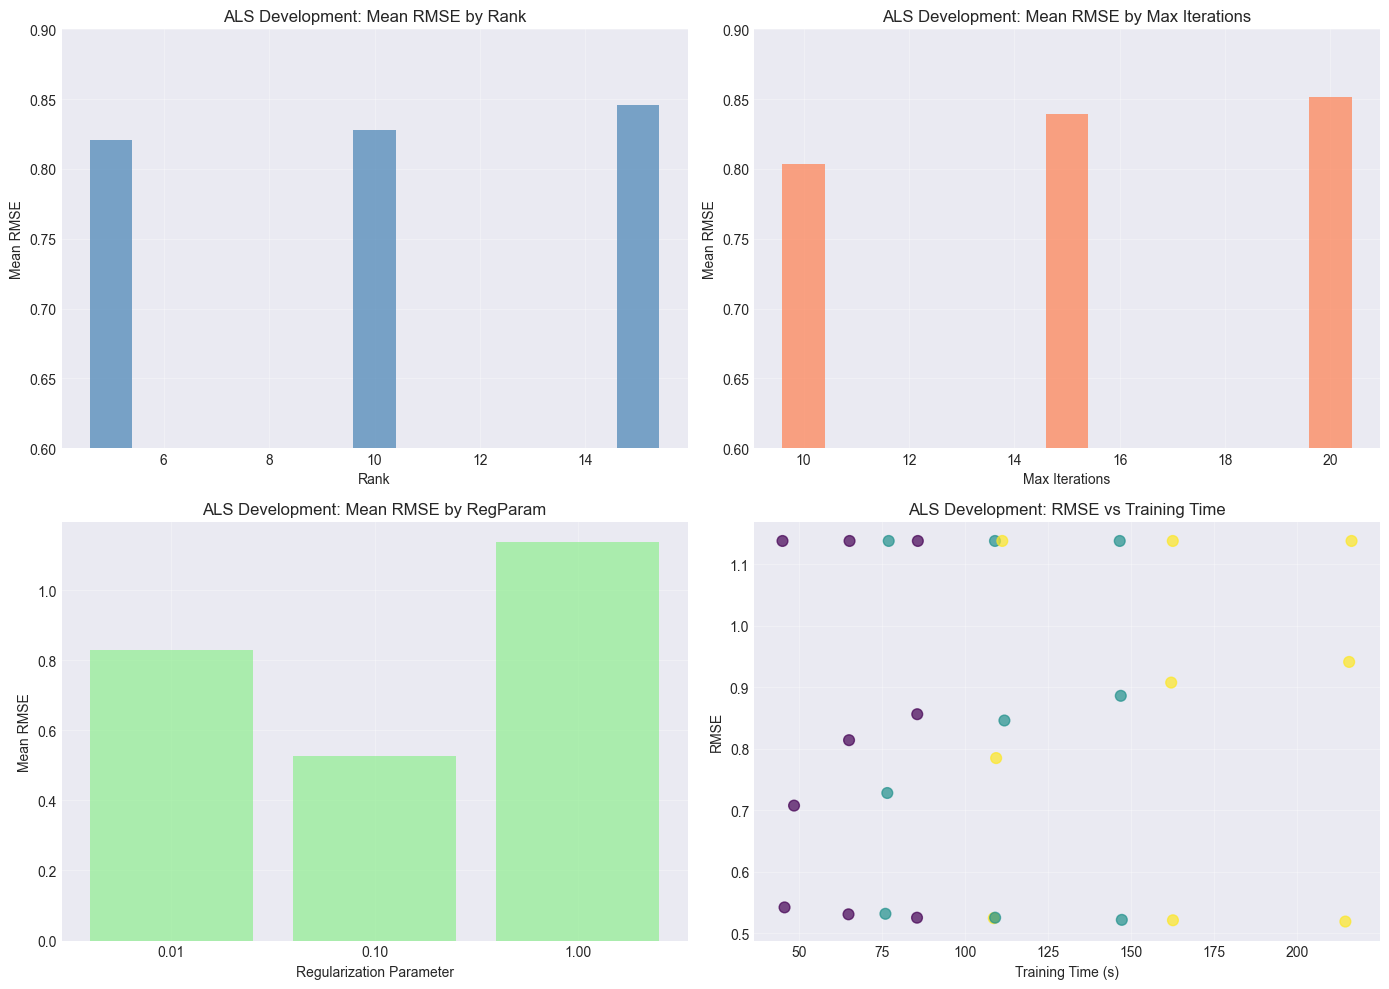

Saved: 04_als_dev_analysis.png

TOP 3 CONFIGURATIONS FOR PRODUCTION

  #1: rank=15, maxIter=20, regParam=0.1 -> RMSE=0.5190
  #2: rank=15, maxIter=15, regParam=0.1 -> RMSE=0.5211
  #3: rank=10, maxIter=20, regParam=0.1 -> RMSE=0.5217


In [12]:
# ALS DEVELOPMENT RESULTS

print("=" * 70)
print("COLLECTING DEVELOPMENT RESULTS")
print("=" * 70 + "\n")

als_dev_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'ALS' AND tags.phase = 'development'"
)

runs_data = []
for run in als_dev_runs:
    run_data = {"run_name": run.info.run_name}
    run_data["model_type"] = run.data.tags["model_type"]
    for key, value in run.data.params.items():
        run_data[key] = value
    for key, value in run.data.metrics.items():
        run_data[key] = value
    runs_data.append(run_data)

results_dev_als_df = pd.DataFrame(runs_data)
results_dev_als_df["rank"] = results_dev_als_df["rank"].astype(int)
results_dev_als_df["maxIter"] = results_dev_als_df["maxIter"].astype(int)
results_dev_als_df["regParam"] = results_dev_als_df["regParam"].astype(float)
results_dev_als_df = results_dev_als_df.sort_values("rmse", ascending=True).reset_index(drop=True)

print(f"Total configurations tested: {len(results_dev_als_df)}")
print(f"\nBest 5 configurations (by RMSE):")
print(results_dev_als_df.head(5).to_string(index=False))
print(f"\nWorst 5 configurations (by RMSE):")
print(results_dev_als_df.tail(5).to_string(index=False))

print(f"\nResults statistics:")
print(f"  Best RMSE: {results_dev_als_df['rmse'].min():.4f}")
print(f"  Worst RMSE: {results_dev_als_df['rmse'].max():.4f}")
print(f"  Mean RMSE: {results_dev_als_df['rmse'].mean():.4f}")
print(f"  Std RMSE: {results_dev_als_df['rmse'].std():.4f}")
print(f"  Avg train time: {results_dev_als_df['train_time'].mean():.1f}s")

# Visualizations
print("\n" + "=" * 70)
print("DEVELOPMENT RESULTS ANALYSIS")
print("=" * 70 + "\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
rank_groups = results_dev_als_df.groupby("rank")["rmse"].mean().sort_index()
ax1.bar(rank_groups.index, rank_groups.values, color="steelblue", alpha=0.7)
ax1.set_xlabel("Rank")
ax1.set_ylabel("Mean RMSE")
ax1.set_ylim(0.6, 0.9)
ax1.set_title("ALS Development: Mean RMSE by Rank")
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
iter_groups = results_dev_als_df.groupby("maxIter")["rmse"].mean().sort_index()
ax2.bar(iter_groups.index, iter_groups.values, color="coral", alpha=0.7)
ax2.set_xlabel("Max Iterations")
ax2.set_ylabel("Mean RMSE")
ax2.set_ylim(0.6, 0.9)
ax2.set_title("ALS Development: Mean RMSE by Max Iterations")
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
reg_groups = results_dev_als_df.groupby("regParam")["rmse"].mean().sort_index()
ax3.bar(range(len(reg_groups)), reg_groups.values, color="lightgreen", alpha=0.7)
ax3.set_xticks(range(len(reg_groups)))
ax3.set_xticklabels([f"{x:.2f}" for x in reg_groups.index])
ax3.set_xlabel("Regularization Parameter")
ax3.set_ylabel("Mean RMSE")
ax3.set_title("ALS Development: Mean RMSE by RegParam")
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.scatter(results_dev_als_df["train_time"], results_dev_als_df["rmse"],
            c=results_dev_als_df["rank"], cmap="viridis", alpha=0.7, s=60)
ax4.set_xlabel("Training Time (s)")
ax4.set_ylabel("RMSE")
ax4.set_title("ALS Development: RMSE vs Training Time")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / "04_als_dev_analysis.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: 04_als_dev_analysis.png")

# Select Top N configs for production
print("\n" + "=" * 70)
print(f"TOP {TOP_N} CONFIGURATIONS FOR PRODUCTION")
print("=" * 70 + "\n")

top_als_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'ALS' AND tags.phase = 'development'",
    order_by=["metrics.rmse ASC"],
    max_results=TOP_N
)

for i, run in enumerate(top_als_runs, 1):
    print(f"  #{i}: rank={run.data.params['rank']}, "
          f"maxIter={run.data.params['maxIter']}, "
          f"regParam={run.data.params['regParam']} "
          f"-> RMSE={run.data.metrics['rmse']:.4f}")

In [11]:
# RELEASE CACHE

print("Releasing cache...")
interactions_dev.unpersist()
train_dev.unpersist()
test_dev.unpersist()
spark.catalog.clearCache()
print("  Cache released")

Releasing cache...
  Cache released


# ALS Production Phase

## Production Training - Full Dataset

La fase di production ri-train le **top 3 configurazioni** identificate in development su **100% del dataset**.

### MLflow Tracking

Runs di production avranno:
- **Tag**: `phase=production`, `sample_fraction=1.0`, `model_path`
- **Metrics**: RMSE, MAE, train_time

In [13]:
# ALS PROD: LOAD & SPLIT DATA

print("=" * 70)
print("ALS PRODUCTION PHASE")
print("=" * 70 + "\n")

# Load
print("Loading full dataset for production training...")
start_time = time.time()

interactions_full = spark.read.format("delta").load(als_data_path)
interactions_count = interactions_full.count()
load_time = time.time() - start_time

print(f"  Full dataset ready: {interactions_count:,} interactions")
print(f"  Verification time: {load_time:.1f} seconds")

# Split
print("\n" + "=" * 70)
print("TRAIN/TEST SPLIT (PRODUCTION)")
print("=" * 70 + "\n")

print(f"Splitting full data ({TRAIN_RATIO}/{TEST_RATIO})...")
train_prod, test_prod = interactions_full.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

ALS PRODUCTION PHASE

Loading full dataset for production training...
  Full dataset ready: 73,874,174 interactions
  Verification time: 0.1 seconds

TRAIN/TEST SPLIT (PRODUCTION)

Splitting full data (0.8/0.2)...


In [14]:
# ALS PROD: TRAIN TOP CONFIGS

print("=" * 70)
print("TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)")
print("=" * 70)

results_prod_als = []

for i, run in enumerate(top_als_runs, 1):

    rank_val = int(run.data.params["rank"])
    maxIter_val = int(run.data.params["maxIter"])
    regParam_val = float(run.data.params["regParam"])
    run_name = f"ALS_prod_r{rank_val}_i{maxIter_val}_reg{regParam_val}"

    print(f"\n[{i}/3] Training: {run_name}")
    print(f"  Config from development: RMSE={run.data.metrics['rmse']:.4f}\n")

    train_start = time.time()

    als = ALS(
        rank=rank_val, maxIter=maxIter_val, regParam=regParam_val,
        userCol="user_id", itemCol="item_id", ratingCol="rating",
        coldStartStrategy="drop", seed=RANDOM_SEED
    )

    model = als.fit(train_prod)
    train_time = time.time() - train_start

    predictions = model.transform(test_prod)
    rmse = rmse_evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)

    log_model(
        run_name=run_name, model_name="ALS_prod", model=model,
        metrics={"rmse": rmse, "mae": mae, "train_time": train_time},
        params={"rank": rank_val, "maxIter": maxIter_val, "regParam": regParam_val, "coldStartStrategy": "drop"},
        tags={"phase": "production", "model_type": "ALS", "sample_fraction": 1.0}
    )

    results_prod_als.append({
        "rank": rank_val, "maxIter": maxIter_val, "regParam": regParam_val,
        "rmse": rmse, "mae": mae, "train_time": train_time
    })
    print(f"\n  Metrics: RMSE={rmse:.4f}, MAE={mae:.4f}, Time={train_time:.1f}s")

TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)

[1/3] Training: ALS_prod_r15_i20_reg0.1
  Config from development: RMSE=0.5190

  Spark model logged to MLflow
    Run ID: fdd02efd0fcc4a3c9123dc54501fe8c7
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/fdd02efd0fcc4a3c9123dc54501fe8c7/

  Metrics: RMSE=0.4736, MAE=0.3164, Time=328.2s

[2/3] Training: ALS_prod_r15_i15_reg0.1
  Config from development: RMSE=0.5211

  Spark model logged to MLflow
    Run ID: 824c1ef016df48eba5e1e4605dbcc1e5
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/824c1ef016df48eba5e1e4605dbcc1e5/

  Metrics: RMSE=0.4726, MAE=0.3153, Time=251.5s

[3/3] Training: ALS_prod_r10_i20_reg0.1
  Config from development: RMSE=0.5217

  Spark model logged to MLflow
    Run ID: 733ab2145ad54863a2f37441f229a27f
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/733ab2145ad54863a2f37441f229a27f/

  Metrics: RMSE=0.4735, MAE=0.3163, Time=229.5s


## Analisi Risultati Production

Confrontiamo i risultati production con development per validare la nostra strategia.

Selezioniamo il **best production model** basandoci su:
1. **RMSE**: Valore piu' basso
2. **Stability**: Performance consistente tra development e production
3. **Efficiency**: A parita' di RMSE, preferiamo model piu' veloce

In [15]:
# ALS PRODUCTION RESULTS

print("=" * 70)
print("COLLECTING PRODUCTION RESULTS")
print("=" * 70 + "\n")

results_prod_als_df = pd.DataFrame(results_prod_als)
results_prod_als_df = results_prod_als_df.sort_values("rmse", ascending=True).reset_index(drop=True)

print(f"All production results:")
print(results_prod_als_df.to_string(index=False))

print(f"\nProduction statistics:")
print(f"  Best RMSE: {results_prod_als_df['rmse'].min():.4f}")
print(f"  Worst RMSE: {results_prod_als_df['rmse'].max():.4f}")
print(f"  Total training time: {results_prod_als_df['train_time'].sum():.1f}s ({results_prod_als_df['train_time'].sum()/60:.1f} min)")

# Dev vs Prod comparison
print("\n" + "=" * 70)
print("PRODUCTION VS DEVELOPMENT COMPARISON")
print("=" * 70 + "\n")

comparison_data = []
for _, prod_row in results_prod_als_df.iterrows():
    dev_row = results_dev_als_df[
        (results_dev_als_df["rank"] == prod_row["rank"]) &
        (results_dev_als_df["maxIter"] == prod_row["maxIter"]) &
        (results_dev_als_df["regParam"] == prod_row["regParam"])
    ].iloc[0]

    comparison_data.append({
        "rank": prod_row["rank"], "maxIter": prod_row["maxIter"],
        "regParam": prod_row["regParam"],
        "dev_rmse": dev_row["rmse"], "prod_rmse": prod_row["rmse"],
        "rmse_diff": prod_row["rmse"] - dev_row["rmse"],
        "dev_time": dev_row["train_time"], "prod_time": prod_row["train_time"],
        "time_factor": prod_row["train_time"] / dev_row["train_time"]
    })

comparison_df = pd.DataFrame(comparison_data)
print("Development vs Production comparison:")
print(comparison_df.to_string(index=False))

print(f"\nKey insights:")
print(f"  Avg RMSE difference: {comparison_df['rmse_diff'].mean():.4f}")
print(f"  Avg time factor (prod/dev): {comparison_df['time_factor'].mean():.1f}x")
print(f"  RMSE correlation: {comparison_df[['dev_rmse', 'prod_rmse']].corr().iloc[0, 1]:.3f}")

save_results(comparison_df, "04_als_dev_vs_prod_comparison.csv")
save_results(results_prod_als_df, "04_als_production_final.csv")

COLLECTING PRODUCTION RESULTS

All production results:
 rank  maxIter  regParam     rmse      mae  train_time
   15       15       0.1 0.472576 0.315339  251.476972
   10       20       0.1 0.473472 0.316278  229.474938
   15       20       0.1 0.473572 0.316385  328.209895

Production statistics:
  Best RMSE: 0.4726
  Worst RMSE: 0.4736
  Total training time: 809.2s (13.5 min)

PRODUCTION VS DEVELOPMENT COMPARISON

Development vs Production comparison:
 rank  maxIter  regParam  dev_rmse  prod_rmse  rmse_diff   dev_time  prod_time  time_factor
 15.0     15.0       0.1  0.521079   0.472576  -0.048503 162.575331 251.476972     1.546834
 10.0     20.0       0.1  0.521743   0.473472  -0.048271 147.191839 229.474938     1.559019
 15.0     20.0       0.1  0.518988   0.473572  -0.045416 214.461576 328.209895     1.530390

Key insights:
  Avg RMSE difference: -0.0474
  Avg time factor (prod/dev): 1.5x
  RMSE correlation: -0.373
Saved: 04_als_dev_vs_prod_comparison.csv
Saved: 04_als_production_

In [16]:
# RELEASE CACHE

print("Releasing cache...")
spark.catalog.clearCache()
print("  Cache released")

Releasing cache...
  Cache released


# Random Forest Classification

## Random Forest Classifier

**Random Forest** e' un ensemble method per classificazione che combina multiple decision trees.

### Come Funziona

1. **Bootstrap Aggregating (Bagging)**: Crea N dataset di training tramite sampling con replacement
2. **Random Feature Selection**: Ogni tree usa un subset random di features (riduce correlation)
3. **Voting**: Predizione finale = majority vote di tutti i trees

### Use Case E-commerce

**Obiettivo**: Classificare customers in segmenti per marketing personalizzato

**Segmenti**:
- **VIP** (~5%): High spenders, loyal customers
- **Regular** (~35%): Medium spenders, regular purchases
- **Occasional** (~60%): Low spenders, infrequent purchases

### Iperparametri

**numTrees**: Numero di trees (10-70)
**maxDepth**: Profondita' massima tree (5-20)
**featureSubsetStrategy**: Features per split (auto = sqrt(n_features))

## Development Phase - Esplorazione Iperparametri

Similmente ad ALS, usiamo **20% sample** per l'esplorazione degli iperparametri.

### Grid Search Strategy

Testeremo **16 combinazioni**:
- `numTrees`: [10, 30, 50, 70]
- `maxDepth`: [5, 10, 15, 20]

### Feature Engineering Pipeline

1. **StringIndexer** per `region` (categorica --> numerica)
2. **StringIndexer** per `customer_segment` (label --> numerica)
3. **VectorAssembler** per combinare features in un vector

In [17]:
# RF DEV: LOAD & SPLIT DATA

print("=" * 70)
print("RANDOM FOREST DEVELOPMENT PHASE (20% SAMPLE)")
print("=" * 70 + "\n")

# Load customer features
print("Loading customer features...")
try:
    customers_full = spark.read.format("delta").load(rf_data_path)
    customers_count = customers_full.count()
    print(f"Loaded {customers_count:,} customer records")
    print("Schema:")
    customers_full.printSchema()
except Exception as e:
    print(f"Error loading customers: {e}")
    raise

# Sample
print(f"\nLoading {SAMPLE_FRACTION_DEV*100:.0f}% sample for development...")
start_time = time.time()
customers_dev = customers_full.sample(fraction=SAMPLE_FRACTION_DEV, seed=RANDOM_SEED)
customers_dev.cache()
customers_dev_count = customers_dev.count()
load_time = time.time() - start_time
print(f"  Sample loaded: {customers_dev_count:,} customers ({load_time:.1f}s)")

# Split
print(f"\nSplitting data ({TRAIN_RATIO}/{TEST_RATIO})...")
train_dev_rf, test_dev_rf = customers_dev.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)
train_dev_rf.cache()
test_dev_rf.cache()

train_dev_rf_count = train_dev_rf.count()
test_dev_rf_count = test_dev_rf.count()
print(f"  Train set: {train_dev_rf_count:,} ({train_dev_rf_count/customers_dev_count*100:.1f}%)")
print(f"  Test set: {test_dev_rf_count:,} ({test_dev_rf_count/customers_dev_count*100:.1f}%)")

print("\nClass distribution - Train:")
train_dev_rf.groupBy("customer_segment").count().orderBy("count", ascending=False).show()


RANDOM FOREST DEVELOPMENT PHASE (20% SAMPLE)

Loading customer features...
Loaded 1,000,000 customer records
Schema:
root
 |-- customer_id: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: long (nullable = true)
 |-- monetary: double (nullable = true)
 |-- avg_transaction: double (nullable = true)
 |-- unique_products: long (nullable = true)
 |-- customer_segment: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- region: string (nullable = true)


Loading 20% sample for development...
  Sample loaded: 200,268 customers (0.7s)

Splitting data (0.8/0.2)...
  Train set: 160,579 (80.2%)
  Test set: 39,689 (19.8%)

Class distribution - Train:
+----------------+-----+
|customer_segment|count|
+----------------+-----+
|      Occasional|96203|
|         Regular|56280|
|             VIP| 8096|
+----------------+-----+



In [18]:
# RF DEV: FEATURE ENGINEERING & GRID SEARCH

print("=" * 70)
print("FEATURE ENGINEERING PIPELINE")
print("=" * 70 + "\n")

print(f"Features: {RF_NUMERIC_FEATURES}")

train_dev_rf_t, test_dev_rf_t, dev_indexer_models = prepare_rf_features(
    train_dev_rf, test_dev_rf, RF_NUMERIC_FEATURES
)
train_dev_rf_t.cache()
test_dev_rf_t.cache()

print("\nFeatures transformed")
print("\nSample transformed features:")
train_dev_rf_t.select("customer_id", "customer_segment", "label", "features").show(5, truncate=False)

num_classes = train_dev_rf_t.select("label").distinct().count()
print(f"Number of classes: {num_classes}")

# Grid Search
print("\n" + "=" * 70)
print("RANDOM FOREST HYPERPARAMETER GRID SEARCH (DEVELOPMENT)")
print("=" * 70 + "\n")

param_grid_rf = {
    "numTrees": [10, 30, 50, 70],
    "maxDepth": [5, 10, 15, 20]
}

all_combinations_rf = list(itertools.product(
    param_grid_rf["numTrees"],
    param_grid_rf["maxDepth"]
))
n_combinations = len(all_combinations_rf)

print(f"Hyperparameter grid:")
print(f"  numTrees: {param_grid_rf['numTrees']}")
print(f"  maxDepth: {param_grid_rf['maxDepth']}")
print(f"\nTotal combinations: {n_combinations}")

results_dev_rf = []

print("\n" + "-" * 70)
print(f"Starting grid search...")
print("-" * 70)

for i, (numTrees_val, maxDepth_val) in enumerate(all_combinations_rf, 1):

    run_name = f"RF_dev_t{numTrees_val}_d{maxDepth_val}"
    print(f"\n[{i}/{n_combinations}] Training: {run_name}\n")

    train_start = time.time()

    rf = RandomForestClassifier(
        numTrees=numTrees_val, maxDepth=maxDepth_val,
        featuresCol="features", labelCol="label",
        seed=RANDOM_SEED, featureSubsetStrategy="auto"
    )

    model = rf.fit(train_dev_rf_t)
    train_time = time.time() - train_start

    predictions = model.transform(test_dev_rf_t)
    accuracy = acc_evaluator.evaluate(predictions)
    f1 = f1_evaluator.evaluate(predictions)

    log_model(
        run_name=run_name, model_name="RF_dev", model=model,
        metrics={"accuracy": accuracy, "f1": f1, "train_time": train_time},
        params={"numTrees": numTrees_val, "maxDepth": maxDepth_val, "featureSubsetStrategy": "auto"},
        tags={"phase": "development", "model_type": "RandomForest", "sample_fraction": SAMPLE_FRACTION_DEV}
    )

    results_dev_rf.append({
        "numTrees": numTrees_val, "maxDepth": maxDepth_val,
        "accuracy": accuracy, "f1": f1, "train_time": train_time
    })
    print(f"\n  Metrics: Accuracy={accuracy:.4f}, F1={f1:.4f}, Time={train_time:.1f}s")

print("\nGrid Search complete")

FEATURE ENGINEERING PIPELINE

Features: ['recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'age']

Features transformed

Sample transformed features:
+-----------+----------------+-----+----------------------------------------------------------------+
|customer_id|customer_segment|label|features                                                        |
+-----------+----------------+-----+----------------------------------------------------------------+
|C00000102  |Regular         |1.0  |[42.0,137.0,50995.560000000005,372.2303649635037,110.0,33.0,4.0]|
|C00000205  |Regular         |1.0  |[39.0,164.0,76116.48999999998,464.1249390243901,121.0,45.0,0.0] |
|C00000278  |Occasional      |0.0  |[47.0,60.0,26345.31,439.0885,52.0,35.0,13.0]                    |
|C00000432  |Regular         |1.0  |[39.0,151.0,61198.96,405.29112582781454,115.0,63.0,1.0]         |
|C00000462  |Occasional      |0.0  |[65.0,41.0,10901.579999999998,265.89219512195115,38.0,48.0,8.0] |
+---------

## Analisi Risultati Development

Analizziamo i risultati della grid search per identificare le migliori tre configurazioni basandoci su:

1. **Accuracy** (primario): Valore piu' alto
2. **Training time** (secondario): A parita' di Accuracy, preferiamo modelli piu' veloci
3. **Generalizzazione**: Configurazioni non troppo complesse

COLLECTING DEVELOPMENT RESULTS

Total configurations tested: 16

All configurations (sorted by accuracy):
      run_name   model_type  numTrees  maxDepth featureSubsetStrategy  accuracy       f1  train_time
RF_dev_t70_d10 RandomForest        70        10                  auto  0.997959 0.997969    2.948974
RF_dev_t10_d10 RandomForest        10        10                  auto  0.997959 0.997971    1.090977
RF_dev_t50_d10 RandomForest        50        10                  auto  0.997934 0.997945    2.177673
RF_dev_t30_d10 RandomForest        30        10                  auto  0.997858 0.997869    1.430209
RF_dev_t50_d20 RandomForest        50        20                  auto  0.997783 0.997791    5.615906
RF_dev_t10_d15 RandomForest        10        15                  auto  0.997783 0.997791    1.393517
RF_dev_t70_d15 RandomForest        70        15                  auto  0.997758 0.997766    5.096466
RF_dev_t30_d20 RandomForest        30        20                  auto  0.997758 0.9977

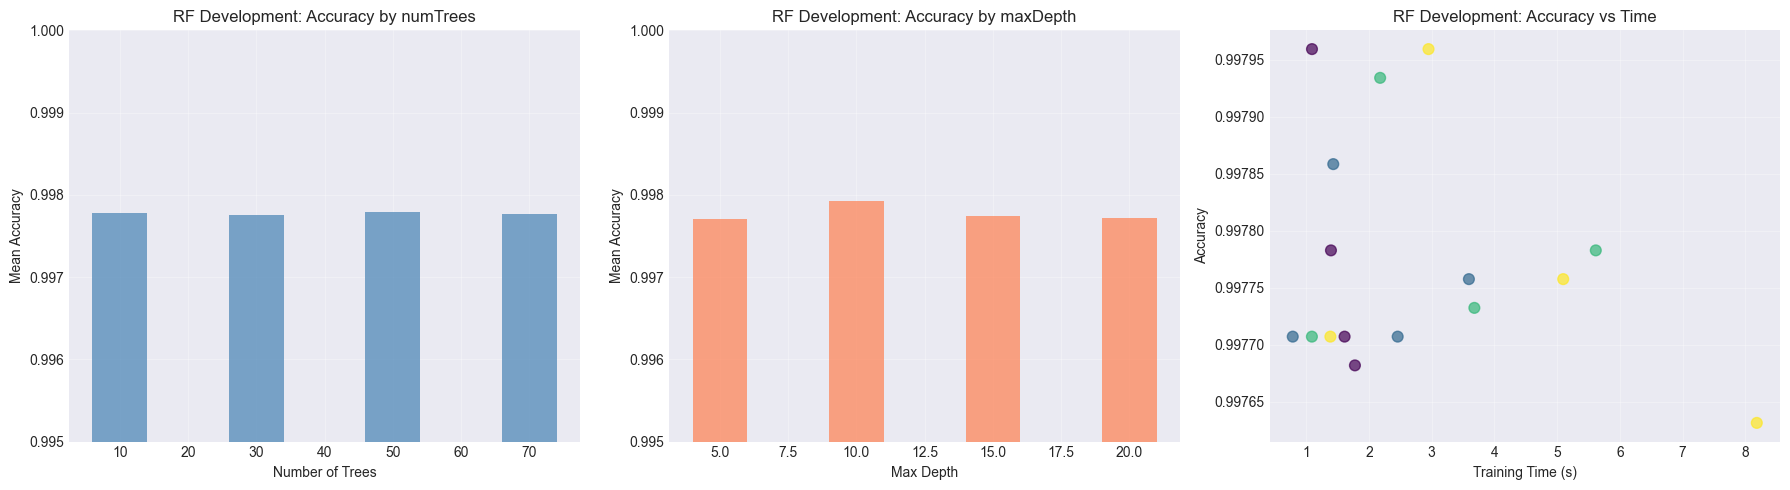

Saved: 04_rf_dev_analysis.png

TOP 3 CONFIGURATIONS FOR PRODUCTION

  #1: numTrees=70, maxDepth=10 -> Accuracy=0.9980
  #2: numTrees=10, maxDepth=10 -> Accuracy=0.9980
  #3: numTrees=50, maxDepth=10 -> Accuracy=0.9979


In [19]:
# RF DEVELOPMENT RESULTS

print("=" * 70)
print("COLLECTING DEVELOPMENT RESULTS")
print("=" * 70 + "\n")

rf_dev_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'RandomForest' AND tags.phase = 'development'"
)

runs_data = []
for run in rf_dev_runs:
    run_data = {"run_name": run.info.run_name, "model_type": run.data.tags["model_type"]}
    for key, value in run.data.params.items():
        run_data[key] = value
    for key, value in run.data.metrics.items():
        run_data[key] = value
    runs_data.append(run_data)

results_dev_rf_df = pd.DataFrame(runs_data)
results_dev_rf_df["numTrees"] = results_dev_rf_df["numTrees"].astype(int)
results_dev_rf_df["maxDepth"] = results_dev_rf_df["maxDepth"].astype(int)
results_dev_rf_df = results_dev_rf_df.sort_values("accuracy", ascending=False).reset_index(drop=True)

print(f"Total configurations tested: {len(results_dev_rf_df)}")
print(f"\nAll configurations (sorted by accuracy):")
print(results_dev_rf_df.to_string(index=False))

print(f"\nResults statistics:")
print(f"  Best accuracy: {results_dev_rf_df['accuracy'].max():.4f}")
print(f"  Worst accuracy: {results_dev_rf_df['accuracy'].min():.4f}")
print(f"  Mean accuracy: {results_dev_rf_df['accuracy'].mean():.4f}")
print(f"  Avg train time: {results_dev_rf_df['train_time'].mean():.1f}s")

# Visualizations
print("\n" + "=" * 70)
print("DEVELOPMENT RESULTS ANALYSIS")
print("=" * 70 + "\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax1 = axes[0]
trees_groups = results_dev_rf_df.groupby("numTrees")["accuracy"].mean().sort_index()
ax1.bar(trees_groups.index, trees_groups.values, color="steelblue", alpha=0.7, width=8)
ax1.set_xlabel("Number of Trees")
ax1.set_ylabel("Mean Accuracy")
ax1.set_ylim(0.995,1)
ax1.set_title("RF Development: Accuracy by numTrees")
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
depth_groups = results_dev_rf_df.groupby("maxDepth")["accuracy"].mean().sort_index()
ax2.bar(depth_groups.index, depth_groups.values, color="coral", alpha=0.7, width=2)
ax2.set_xlabel("Max Depth")
ax2.set_ylabel("Mean Accuracy")
ax2.set_ylim(0.995,1)
ax2.set_title("RF Development: Accuracy by maxDepth")
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
ax3.scatter(results_dev_rf_df["train_time"], results_dev_rf_df["accuracy"],
            c=results_dev_rf_df["numTrees"], cmap="viridis", alpha=0.7, s=60)
ax3.set_xlabel("Training Time (s)")
ax3.set_ylabel("Accuracy")
ax3.set_title("RF Development: Accuracy vs Time")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / "04_rf_dev_analysis.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: 04_rf_dev_analysis.png")

# Select Top N
print("\n" + "=" * 70)
print(f"TOP {TOP_N} CONFIGURATIONS FOR PRODUCTION")
print("=" * 70 + "\n")

top_rf_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'RandomForest' AND tags.phase = 'development'",
    order_by=["metrics.accuracy DESC"],
    max_results=TOP_N
)

for i, run in enumerate(top_rf_runs, 1):
    print(f"  #{i}: numTrees={run.data.params['numTrees']}, "
          f"maxDepth={run.data.params['maxDepth']} "
          f"-> Accuracy={run.data.metrics['accuracy']:.4f}")

In [20]:
# RELEASE CACHE

print("Releasing cache...")
customers_dev.unpersist()
train_dev_rf.unpersist()
test_dev_rf.unpersist()
train_dev_rf_t.unpersist()
test_dev_rf_t.unpersist()
spark.catalog.clearCache()
print("  Cache released")

Releasing cache...
  Cache released


# Random Forest Production Phase

La fase di production ri-train le **top 3 configurazioni** su **100% del dataset**.

### MLflow Tracking

Runs di production avranno:
- **Tag**: `phase=production`, `sample_fraction=1.0`
- **Metrics**: Accuracy, F1, train_time

In [21]:
# RF PROD: LOAD, SPLIT & FEATURE ENGINERING

print("=" * 70)
print("RF PRODUCTION PHASE")
print("=" * 70 + "\n")

# Load full data
print("Loading full customer dataset for production training...")
customers_full = spark.read.format("delta").load(rf_data_path)
customers_count = customers_full.count()
print(f"Loaded {customers_count:,} customer records")

# Split
print(f"\nSplitting full data ({TRAIN_RATIO}/{TEST_RATIO})...")
train_prod_rf, test_prod_rf = customers_full.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

# Feature engineering (reusing helper function)
print("\nApplying feature transformations (production)...")
train_prod_rf_t, test_prod_rf_t, prod_indexer_models = prepare_rf_features(
    train_prod_rf, test_prod_rf, RF_NUMERIC_FEATURES
)
train_prod_rf_t.cache()
test_prod_rf_t.cache()

train_prod_rf_count = train_prod_rf_t.count()
test_prod_rf_count = test_prod_rf_t.count()
print(f"  Train transformed and cached: {train_prod_rf_count:,} customers")
print(f"  Test transformed and cached: {test_prod_rf_count:,} customers")

RF PRODUCTION PHASE

Loading full customer dataset for production training...
Loaded 1,000,000 customer records

Splitting full data (0.8/0.2)...

Applying feature transformations (production)...
  Train transformed and cached: 800,344 customers
  Test transformed and cached: 199,656 customers


In [22]:
# RF PROD: TRAIN TOP CONFIGS

print("=" * 70)
print("TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)")
print("=" * 70)

results_prod_rf = []

for i, run in enumerate(top_rf_runs, 1):

    numTrees_val = int(run.data.params["numTrees"])
    maxDepth_val = int(run.data.params["maxDepth"])
    run_name = f"RF_prod_t{numTrees_val}_d{maxDepth_val}"

    print(f"\n[{i}/{TOP_N}] Training: {run_name}")
    print(f"  Config from development: Accuracy={run.data.metrics['accuracy']:.4f}\n")

    train_start = time.time()

    rf = RandomForestClassifier(
        numTrees=numTrees_val, maxDepth=maxDepth_val,
        featuresCol="features", labelCol="label",
        seed=RANDOM_SEED, featureSubsetStrategy="auto"
    )

    model = rf.fit(train_prod_rf_t)
    train_time = time.time() - train_start

    predictions = model.transform(test_prod_rf_t)
    accuracy = acc_evaluator.evaluate(predictions)
    f1 = f1_evaluator.evaluate(predictions)

    log_model(
        run_name=run_name, model_name="RF_prod", model=model,
        metrics={"accuracy": accuracy, "f1": f1, "train_time": train_time},
        params={"numTrees": numTrees_val, "maxDepth": maxDepth_val, "featureSubsetStrategy": "auto"},
        tags={"phase": "production", "model_type": "RandomForest", "sample_fraction": 1.0}
    )

    results_prod_rf.append({
        "numTrees": numTrees_val, "maxDepth": maxDepth_val,
        "accuracy": accuracy, "f1": f1, "train_time": train_time
    })
    print(f"\n  Metrics: Accuracy={accuracy:.4f}, F1={f1:.4f}, Time={train_time:.1f}s")

TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)

[1/3] Training: RF_prod_t70_d10
  Config from development: Accuracy=0.9980

  Spark model logged to MLflow
    Run ID: 5c7b89421eb741c49f42880b3659e2d9
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/5c7b89421eb741c49f42880b3659e2d9/

  Metrics: Accuracy=0.9976, F1=0.9976, Time=10.9s

[2/3] Training: RF_prod_t10_d10
  Config from development: Accuracy=0.9980

  Spark model logged to MLflow
    Run ID: ae9387bf420c46cda9aca7abdea78314
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/ae9387bf420c46cda9aca7abdea78314/

  Metrics: Accuracy=0.9976, F1=0.9976, Time=2.2s

[3/3] Training: RF_prod_t50_d10
  Config from development: Accuracy=0.9979

  Spark model logged to MLflow
    Run ID: e722f494930244ab8ad920334146dcc6
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/e722f494930244ab8ad920334146dcc6/

  Metrics: Accuracy=0.9976, F1=0.9976, Time=7.5s


In [23]:
# RF PRODUCTION RESULTS

print("=" * 70)
print("PRODUCTION RESULTS COLLECTION (RF)")
print("=" * 70 + "\n")

results_prod_rf_df = pd.DataFrame(results_prod_rf)
results_prod_rf_df = results_prod_rf_df.sort_values("accuracy", ascending=False).reset_index(drop=True)

print("Production training complete!")
print(f"\nAll production results:")
print(results_prod_rf_df.to_string(index=False))

print(f"\nProduction statistics:")
print(f"  Best accuracy: {results_prod_rf_df['accuracy'].max():.4f}")
print(f"  Worst accuracy: {results_prod_rf_df['accuracy'].min():.4f}")
print(f"  Total training time: {results_prod_rf_df['train_time'].sum():.1f}s ({results_prod_rf_df['train_time'].sum()/60:.1f} min)")

# Dev vs Prod comparison
print("\n" + "=" * 70)
print("PRODUCTION VS DEVELOPMENT COMPARISON (RF)")
print("=" * 70 + "\n")

comparison_data_rf = []
for _, prod_row in results_prod_rf_df.iterrows():
    dev_row = results_dev_rf_df[
        (results_dev_rf_df["numTrees"] == prod_row["numTrees"]) &
        (results_dev_rf_df["maxDepth"] == prod_row["maxDepth"])
    ].iloc[0]

    comparison_data_rf.append({
        "numTrees": prod_row["numTrees"], "maxDepth": prod_row["maxDepth"],
        "dev_accuracy": dev_row["accuracy"], "prod_accuracy": prod_row["accuracy"],
        "accuracy_diff": prod_row["accuracy"] - dev_row["accuracy"],
        "dev_time": dev_row["train_time"], "prod_time": prod_row["train_time"],
        "time_factor": prod_row["train_time"] / dev_row["train_time"]
    })

comparison_rf_df = pd.DataFrame(comparison_data_rf)
print("Development vs Production comparison:")
print(comparison_rf_df.to_string(index=False))

print(f"\nKey insights:")
print(f"  Avg accuracy difference: {comparison_rf_df['accuracy_diff'].mean():.4f}")
print(f"  Avg time factor (prod/dev): {comparison_rf_df['time_factor'].mean():.1f}x")
print(f"  Accuracy correlation: {comparison_rf_df[['dev_accuracy', 'prod_accuracy']].corr().iloc[0, 1]:.3f}")

save_results(comparison_rf_df, "04_rf_dev_vs_prod_comparison.csv")
save_results(results_prod_rf_df, "04_rf_production_final.csv")

PRODUCTION RESULTS COLLECTION (RF)

Production training complete!

All production results:
 numTrees  maxDepth  accuracy       f1  train_time
       70        10  0.997641 0.997646   10.946937
       50        10  0.997636 0.997640    7.490877
       10        10  0.997581 0.997589    2.222142

Production statistics:
  Best accuracy: 0.9976
  Worst accuracy: 0.9976
  Total training time: 20.7s (0.3 min)

PRODUCTION VS DEVELOPMENT COMPARISON (RF)

Development vs Production comparison:
 numTrees  maxDepth  dev_accuracy  prod_accuracy  accuracy_diff  dev_time  prod_time  time_factor
     70.0      10.0      0.997959       0.997641      -0.000318  2.948974  10.946937     3.712118
     50.0      10.0      0.997934       0.997636      -0.000298  2.177673   7.490877     3.439853
     10.0      10.0      0.997959       0.997581      -0.000378  1.090977   2.222142     2.036837

Key insights:
  Avg accuracy difference: -0.0003
  Avg time factor (prod/dev): 3.1x
  Accuracy correlation: -0.434
Sav

In [24]:
# RELEASE CACHE

print("Releasing cache...")
train_prod_rf_t.unpersist()
test_prod_rf_t.unpersist()
spark.catalog.clearCache()
print("  Cache released")

Releasing cache...
  Cache released


# Selezione Modelli

## Modelli in MLflow

In questa parte analizziamo **tutti** gli esperimenti tracciati in MLflow per selezionare i modelli migliori.

### Esperimenti Totali

**Experiment name**: `ecommerce-ml-models`

**Runs attesi**:
- ALS Development: 27 runs (grid search)
- ALS Production: 3 runs (top configs)
- RF Development: 16 runs (grid search)
- RF Production: 3 runs (top configs)
- **Totale**: 49 runs

### Threshold di Successo

**ALS**: RMSE < 1.0 (Buono), RMSE < 0.8 (Eccellente), RMSE < 0.5 (Outstanding)
**RF**: Accuracy > 85% (Minimo), Accuracy > 90% (Buono), Accuracy > 95% (Eccellente)

## MLflow & MinIO Runs Screenshots

**MLflow Runs**

<img src="./screenshots/04_mlflow_runs.png" alt="MLFlow Runs" >

**MinIO Runs Storage**

<img src="./screenshots/04_minio_runs.png" alt="MinIO Runs" >

ALS MODELS COMPARISON

Production ALS models (sorted by RMSE):
               run_name rank maxIter regParam     rmse      mae  train_time
ALS_prod_r15_i15_reg0.1   15      15      0.1 0.472576 0.315339  251.476972
ALS_prod_r10_i20_reg0.1   10      20      0.1 0.473472 0.316278  229.474938
ALS_prod_r15_i20_reg0.1   15      20      0.1 0.473572 0.316385  328.209895

ALS Statistics:
  Best RMSE: 0.4726
  Worst RMSE: 0.4736
  RMSE range: 0.0010


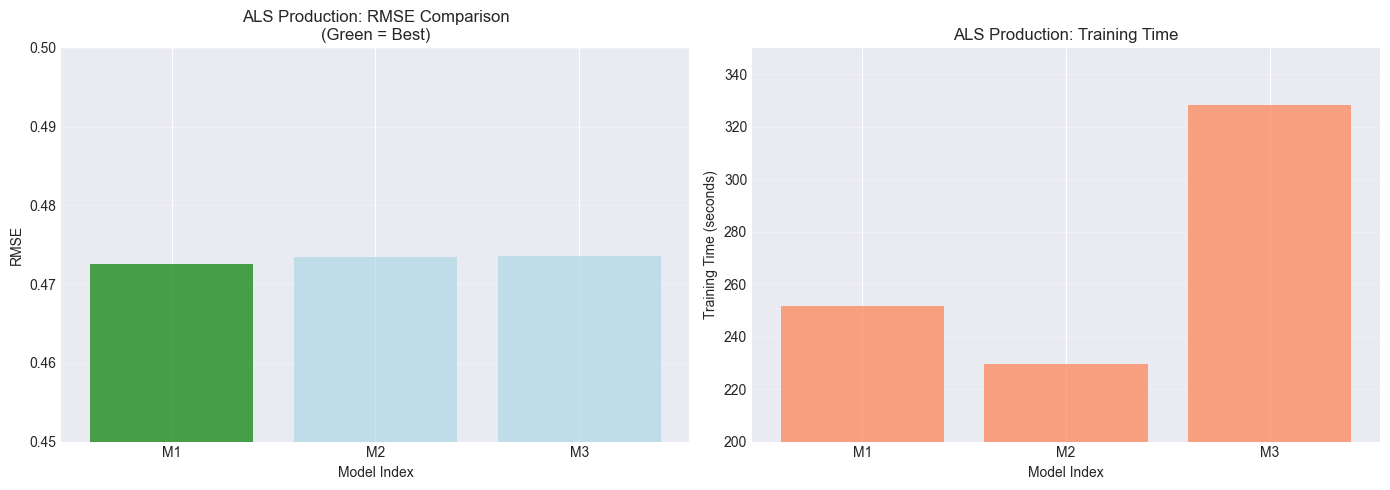

Saved: 04_als_production_comparison.png


In [25]:
# ALS COMPARISON TABLE

print("=" * 70)
print("ALS MODELS COMPARISON")
print("=" * 70 + "\n")

als_prod_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'ALS' AND tags.phase = 'production'"
)

runs_data = []
for run in als_prod_runs:
    run_data = {"run_name": run.info.run_name, "model_type": run.data.tags["model_type"]}
    for key, value in run.data.params.items():
        run_data[key] = value
    for key, value in run.data.metrics.items():
        run_data[key] = value
    runs_data.append(run_data)

als_comparison = pd.DataFrame(runs_data)
als_comparison = als_comparison.sort_values(by="rmse", ascending=True).reset_index(drop=True)

print("Production ALS models (sorted by RMSE):")
print(als_comparison[["run_name", "rank", "maxIter", "regParam", "rmse", "mae", "train_time"]].to_string(index=False))

print(f"\nALS Statistics:")
print(f"  Best RMSE: {als_comparison['rmse'].min():.4f}")
print(f"  Worst RMSE: {als_comparison['rmse'].max():.4f}")
print(f"  RMSE range: {als_comparison['rmse'].max() - als_comparison['rmse'].min():.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
colors = ["green" if i == 0 else "lightblue" for i in range(len(als_comparison))]
ax1.bar(range(len(als_comparison)), als_comparison["rmse"], color=colors, alpha=0.7)
ax1.set_xlabel("Model Index")
ax1.set_ylabel("RMSE")
ax1.set_ylim(0.45, 0.5)
ax1.set_title("ALS Production: RMSE Comparison\n(Green = Best)")
ax1.set_xticks(range(len(als_comparison)))
ax1.set_xticklabels([f"M{i+1}" for i in range(len(als_comparison))])
ax1.grid(True, alpha=0.3, axis="y")

ax2 = axes[1]
ax2.bar(range(len(als_comparison)), als_comparison["train_time"], color="coral", alpha=0.7)
ax2.set_xlabel("Model Index")
ax2.set_ylabel("Training Time (seconds)")
ax2.set_ylim(200, 350)
ax2.set_title("ALS Production: Training Time")
ax2.set_xticks(range(len(als_comparison)))
ax2.set_xticklabels([f"M{i+1}" for i in range(len(als_comparison))])
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(GRAPH_DIR / "04_als_production_comparison.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: 04_als_production_comparison.png")

RF MODELS COMPARISON

Production RF models (sorted by Accuracy):
       run_name numTrees maxDepth  accuracy       f1  train_time
RF_prod_t70_d10       70       10  0.997641 0.997646   10.946937
RF_prod_t50_d10       50       10  0.997636 0.997640    7.490877
RF_prod_t10_d10       10       10  0.997581 0.997589    2.222142

RF Statistics:
  Best accuracy: 0.9976
  Worst accuracy: 0.9976
  Accuracy range: 0.0001


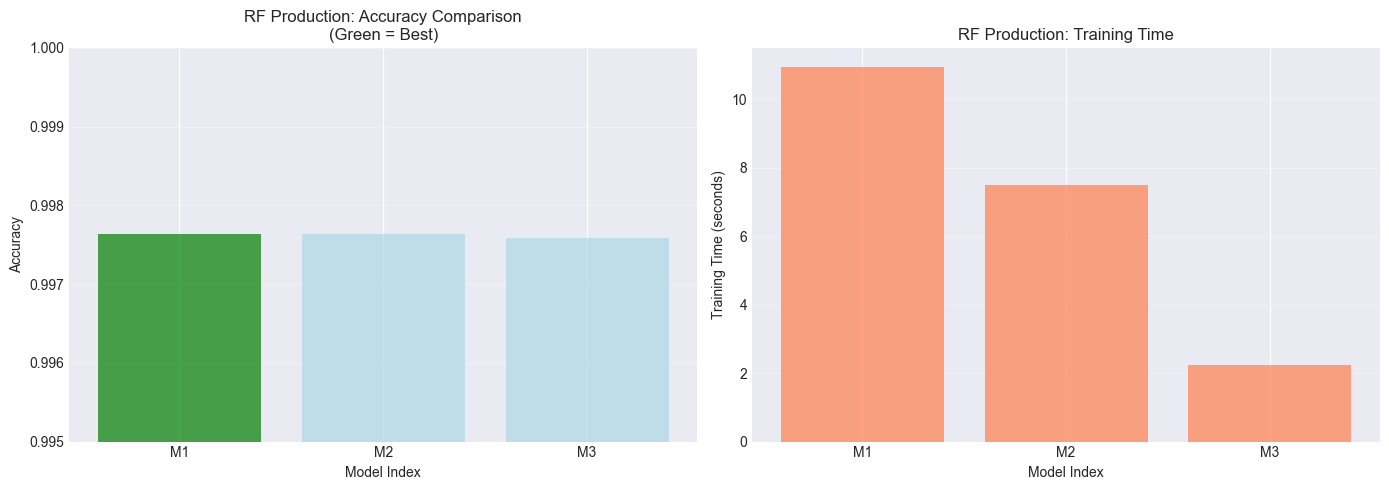

Saved: 04_rf_production_comparison.png


In [26]:
# RF COMPARISON TABLE

print("=" * 70)
print("RF MODELS COMPARISON")
print("=" * 70 + "\n")

rf_prod_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'RandomForest' AND tags.phase = 'production'"
)

runs_data = []
for run in rf_prod_runs:
    run_data = {"run_name": run.info.run_name, "model_type": run.data.tags["model_type"]}
    for key, value in run.data.params.items():
        run_data[key] = value
    for key, value in run.data.metrics.items():
        run_data[key] = value
    runs_data.append(run_data)

rf_comparison = pd.DataFrame(runs_data)
rf_comparison = rf_comparison.sort_values(by="accuracy", ascending=False).reset_index(drop=True)

print("Production RF models (sorted by Accuracy):")
print(rf_comparison[["run_name", "numTrees", "maxDepth", "accuracy", "f1", "train_time"]].to_string(index=False))

print(f"\nRF Statistics:")
print(f"  Best accuracy: {rf_comparison['accuracy'].max():.4f}")
print(f"  Worst accuracy: {rf_comparison['accuracy'].min():.4f}")
print(f"  Accuracy range: {rf_comparison['accuracy'].max() - rf_comparison['accuracy'].min():.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
colors = ["green" if i == 0 else "lightblue" for i in range(len(rf_comparison))]
ax1.bar(range(len(rf_comparison)), rf_comparison["accuracy"], color=colors, alpha=0.7)
ax1.set_xlabel("Model Index")
ax1.set_ylabel("Accuracy")
ax1.set_ylim(0.995,1)
ax1.set_title("RF Production: Accuracy Comparison\n(Green = Best)")
ax1.set_xticks(range(len(rf_comparison)))
ax1.set_xticklabels([f"M{i+1}" for i in range(len(rf_comparison))])
ax1.grid(True, alpha=0.3, axis="y")

ax2 = axes[1]
ax2.bar(range(len(rf_comparison)), rf_comparison["train_time"], color="coral", alpha=0.7)
ax2.set_xlabel("Model Index")
ax2.set_ylabel("Training Time (seconds)")
ax2.set_title("RF Production: Training Time")
ax2.set_xticks(range(len(rf_comparison)))
ax2.set_xticklabels([f"M{i+1}" for i in range(len(rf_comparison))])
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(GRAPH_DIR / "04_rf_production_comparison.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: 04_rf_production_comparison.png")

In [27]:
# SELECT & REGISTER BEST MODELS

print("=" * 70)
print("BEST MODEL SELECTION")
print("=" * 70 + "\n")

# Best ALS (lowest RMSE)
best_als = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'ALS' AND tags.phase = 'production'",
    order_by=["metrics.rmse ASC"],
    max_results=1
)[0]

print("BEST ALS MODEL:")
print(f"  Run name:   {best_als.info.run_name}")
print(f"  Run ID: {best_als.info.run_id}")
print(f"  Configuration:")
print(f"    - rank:     {int(best_als.data.params['rank'])}")
print(f"    - maxIter:  {int(best_als.data.params['maxIter'])}")
print(f"    - regParam: {float(best_als.data.params['regParam'])}")
print(f"  Performance:")
print(f"    - RMSE: {best_als.data.metrics['rmse']:.4f}")
print(f"    - MAE:  {best_als.data.metrics['mae']:.4f}")

# Best RF (highest accuracy)
best_rf = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'RandomForest' AND tags.phase = 'production'",
    order_by=["metrics.accuracy DESC"],
    max_results=1
)[0]

print("\nBEST RF MODEL:")
print(f"  Run name: {best_rf.info.run_name}")
print(f"  Run ID: {best_rf.info.run_id}")
print(f"  Configuration:")
print(f"    - numTrees: {int(best_rf.data.params['numTrees'])}")
print(f"    - maxDepth: {int(best_rf.data.params['maxDepth'])}")
print(f"  Performance:")
print(f"    - Accuracy: {best_rf.data.metrics['accuracy']:.4f}")
print(f"    - F1:       {best_rf.data.metrics['f1']:.4f}")

# Register in MLflow Model Registry
print("\n" + "=" * 70)
print("MLFLOW MODEL REGISTRY")
print("=" * 70 + "\n")

print("Registering best models in MLflow Model Registry...")

als_model_uri = f"s3://bigdata-ecommerce/mlflow-artifacts/{best_als.info.run_id}/artifacts/ALS_prod"
als_model_name = "ALS_Recommender_Production"

rf_model_uri = f"s3://bigdata-ecommerce/mlflow-artifacts/{best_rf.info.run_id}/artifacts/RF_prod"
rf_model_name = "RF_Classifier_Production"

try:
    print("\n[1/2] Registering ALS model...")
    als_mv = mlflow.register_model(als_model_uri, als_model_name)
    print(f"  Registered: {als_model_name} (version {als_mv.version})")

    print("\n[2/2] Registering RF model...")
    rf_mv = mlflow.register_model(rf_model_uri, rf_model_name)
    print(f"  Registered: {rf_model_name} (version {rf_mv.version})")

    print("\nModel registration complete!")

except Exception as e:
    print(f"  Registration error: {e}")
    print("  Models are still saved as MLflow runs and can be loaded by run_id.")

BEST MODEL SELECTION

BEST ALS MODEL:
  Run name:   ALS_prod_r15_i15_reg0.1
  Run ID: 824c1ef016df48eba5e1e4605dbcc1e5
  Configuration:
    - rank:     15
    - maxIter:  15
    - regParam: 0.1
  Performance:
    - RMSE: 0.4726
    - MAE:  0.3153

BEST RF MODEL:
  Run name: RF_prod_t70_d10
  Run ID: 5c7b89421eb741c49f42880b3659e2d9
  Configuration:
    - numTrees: 70
    - maxDepth: 10
  Performance:
    - Accuracy: 0.9976
    - F1:       0.9976

MLFLOW MODEL REGISTRY

Registering best models in MLflow Model Registry...

[1/2] Registering ALS model...


Successfully registered model 'ALS_Recommender_Production'.
2026/02/07 13:12:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ALS_Recommender_Production, version 1
Created version '1' of model 'ALS_Recommender_Production'.
Successfully registered model 'RF_Classifier_Production'.
2026/02/07 13:12:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RF_Classifier_Production, version 1


  Registered: ALS_Recommender_Production (version 1)

[2/2] Registering RF model...
  Registered: RF_Classifier_Production (version 1)

Model registration complete!


Created version '1' of model 'RF_Classifier_Production'.


# Production Deployment

Tutti i modelli sono salvati in MLflow e possono essere caricati e utilizzati per eseguire predizioni su larga scala.

1. **ALS: Recommendations Generation**
   - **Input**: User-Item matrix (tutti gli users)
   - **Output**: Top-N items per user
   - **Method**: `model.recommendForAllUsers(N)`

2. **RF: Customer Segmentation**
   - **Input**: Customer features (tutti i customers)
   - **Output**: Segment prediction + probability
   - **Method**: `model.transform(features_df)`

Eseguiremo le predizioni con i modelli precedentemente selezionati.

In [28]:
# PREDICTIONS ALS

print("=" * 70)
print("BATCH PREDICTIONS PIPELINE - ALS RECOMMENDER")
print("=" * 70 + "\n")

print("Loading ALS model...")
try:
    loaded_als_model = mlflow.spark.load_model(als_model_uri)
    als_model = loaded_als_model.stages[-1]
    print(f"  ALS model loaded successfully")
    print(f"  Type: {type(loaded_als_model)}")
    print(f"  Last Stage: {type(als_model)}")
except Exception as e:
    print(f"  Error loading ALS model: {e}")

print("\nGenerating recommendations for all users (batch processing)...")

print("\n[1/2] Generate Top-10 recommendations for all users")
start_time = time.time()
user_recs = als_model.recommendForAllUsers(10)
total_users = user_recs.count()
rec_time = time.time() - start_time

print(f"  Generated recommendations for {total_users:,} users in {rec_time:.1f}s")
print(f"  Throughput: {total_users/rec_time:.0f} users/second")

# Explode recommendations
print("\nExploding recommendations for analysis...")
recs_exploded = user_recs.select(
    F.col("user_id"),
    F.explode(F.col("recommendations")).alias("recommendation")
).select(
    F.col("user_id"),
    F.col("recommendation.item_id").alias("item_id"),
    F.col("recommendation.rating").alias("predicted_rating")
)
print(f"  Total recommendations: {recs_exploded.count():,}")

print("\nSample exploded recommendations:")
recs_exploded.show(10, truncate=False)

# Save to Delta Lake
print("\n[2/2] Saving recommendations to Delta Lake...")
recs_output_path = f"{predictions_path}/recommendations_output"
try:
    recs_exploded.write.format("delta").mode("overwrite").save(recs_output_path)
    print(f"Saved to: {recs_output_path}")
except Exception as e:
    print(f"Could not save to Delta Lake: {e}")

print("\nALS batch predictions complete")

BATCH PREDICTIONS PIPELINE - ALS RECOMMENDER

Loading ALS model...
  ALS model loaded successfully
  Type: <class 'pyspark.ml.pipeline.PipelineModel'>
  Last Stage: <class 'pyspark.ml.recommendation.ALSModel'>

Generating recommendations for all users (batch processing)...

[1/2] Generate Top-10 recommendations for all users
  Generated recommendations for 1,000,000 users in 183.9s
  Throughput: 5439 users/second

Exploding recommendations for analysis...
  Total recommendations: 10,000,000

Sample exploded recommendations:
+-------+-------+----------------+
|user_id|item_id|predicted_rating|
+-------+-------+----------------+
|14     |1      |6.6024733       |
|14     |2      |5.9746146       |
|14     |8      |5.5393085       |
|14     |11     |5.467192        |
|14     |16     |5.4288073       |
|14     |18     |5.363495        |
|14     |37172  |5.2189517       |
|14     |22320  |5.2137194       |
|14     |34204  |5.2110567       |
|14     |26171  |5.209457        |
+-------+------

BATCH PREDICTIONS PIPELINE - RF CLASSIFIER

Loading RF model...
  RF model loaded successfully
  Type: <class 'pyspark.ml.pipeline.PipelineModel'>
  Last Stage: <class 'pyspark.ml.classification.RandomForestClassificationModel'>

Loading customer features...
Loaded 1,000,000 customer records

[1/3] Transform and predict for all customers
  Classified 1,000,000 customers in 0.5s
  Throughput: 1887248 customers/second

[2/3] Prediction distribution:
+-----------+-------+---------+------------------+------------------+---------------+----------------+---+--------+--------------+-----+--------------------+--------------------+--------------------+----------+
|customer_id|recency|frequency|          monetary|   avg_transaction|unique_products|customer_segment|age|  region|region_indexed|label|            features|       rawPrediction|         probability|prediction|
+-----------+-------+---------+------------------+------------------+---------------+----------------+---+--------+-----------

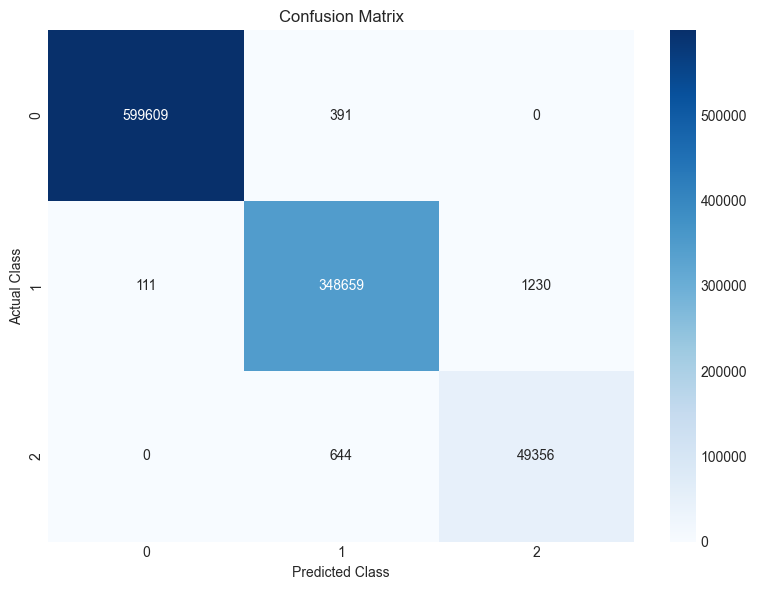


[3/3] Saving predictions to Delta Lake...
Saved to: s3a://bigdata-ecommerce/predictions/segmentation_output

RF batch predictions complete


In [30]:
# PREDICTIONS RF

print("=" * 70)
print("BATCH PREDICTIONS PIPELINE - RF CLASSIFIER")
print("=" * 70 + "\n")

print("Loading RF model...")
try:
    loaded_rf_model = mlflow.spark.load_model(rf_model_uri)
    rf_model = loaded_rf_model.stages[-1]
    print(f"  RF model loaded successfully")
    print(f"  Type: {type(loaded_rf_model)}")
    print(f"  Last Stage: {type(rf_model)}")
except Exception as e:
    print(f"  Error loading RF model: {e}")

print("\nLoading customer features...")
customers_full = spark.read.format("delta").load(rf_data_path)
customers_count = customers_full.count()
print(f"Loaded {customers_count:,} customer records")

# Transform features
print("\n[1/3] Transform and predict for all customers")
start_time = time.time()

# Fit indexers on full data
string_indexer_full = StringIndexer(inputCol="region", outputCol="region_indexed", handleInvalid="keep")
label_indexer_full = StringIndexer(inputCol="customer_segment", outputCol="label", handleInvalid="keep")
assembler_full = VectorAssembler(inputCols=RF_NUMERIC_FEATURES + ["region_indexed"], outputCol="features", handleInvalid="keep")

string_indexer_model_full = string_indexer_full.fit(customers_full)
label_indexer_model_full = label_indexer_full.fit(customers_full)

customers_full_indexed = string_indexer_model_full.transform(customers_full)
customers_full_indexed = label_indexer_model_full.transform(customers_full_indexed)
customers_full_transformed = assembler_full.transform(customers_full_indexed)

# Predict
all_predictions = rf_model.transform(customers_full_transformed)
total_customers = all_predictions.count()
pred_time = time.time() - start_time

print(f"  Classified {total_customers:,} customers in {pred_time:.1f}s")
print(f"  Throughput: {total_customers/pred_time:.0f} customers/second")

# Distribution
print("\n[2/3] Prediction distribution:")
all_predictions.show(5)
all_predictions.groupBy("prediction").count().orderBy("prediction").show()

# Confusion Matrix
print("\nConfusion Matrix")
preds_and_labels = all_predictions.select("prediction", "label").rdd.map(lambda r: (float(r[0]), float(r[1])))
metrics_obj = MulticlassMetrics(preds_and_labels)
print(f"  Overall Accuracy: {metrics_obj.accuracy:.4f}")

# Get confusion matrix
confusion_matrix = metrics_obj.confusionMatrix().toArray()

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: 04_rf_confusion_matrix.png")
plt.show()

# Save predictions
print("\n[3/3] Saving predictions to Delta Lake...")
predictions_output_path = f"{predictions_path}/segmentation_output"
pred_to_save = all_predictions.select("customer_id", "customer_segment", "prediction", "probability")

try:
    pred_to_save.write.format("delta").mode("overwrite").save(predictions_output_path)
    print(f"Saved to: {predictions_output_path}")
except Exception as e:
    print(f"Could not save to Delta Lake: {e}")

print("\nRF batch predictions complete")

In [31]:
# CLEANUP

# Release all cache
print("Releasing cache...")
spark.catalog.clearCache()
print("  Cache released")

# Stop Spark
print("\nStopping Spark session...")
spark.stop()
print("  Spark session stopped.")

Releasing cache...
  Cache released

Stopping Spark session...
  Spark session stopped.


## MinIO Predictions Storage Screenshots

**ALS Predictions**

<img src="./screenshots/04_minio_pred_als.png" alt="MinIO ALS Predictions" >

**ALS Predictions**

<img src="./screenshots/04_minio_pred_rf.png" alt="MinIO RF Predictions" >